In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from spFA.spFA.spFA import spFA
import scanpy as sc
import torch
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from spFA.spFA.plots import plot_top_weights, plot_weights, plot_variance_explained_view,plot_variance_explained
import matplotlib
import anndata
import umap


/home/capraz/hubershare/anaconda3/lib/python3.8/site-packages/torch/onnx/_internal/_beartype.py:30: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")
/home/capraz/hubershare/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
rna = pd.read_csv("pbmc5k/pbmc5k_rna.csv", index_col=0)
adt = pd.read_csv("pbmc5k/pbmc5k_adt.csv", index_col=0)
obs = pd.read_csv("pbmc5k/pbmc5k_obs.csv", index_col=0)

In [4]:
rna_pca = PCA(50).fit_transform(rna)


In [5]:
um = umap.UMAP(n_neighbors=30)
rna_umap=um.fit_transform(rna_pca)


In [6]:
um = umap.UMAP()
adt_umap=um.fit_transform(adt)

In [7]:
# convert string labels to numeric
obs["lowlevel"] = obs["lowlevel"].fillna("nan")
lowlevel_map = {lab:i for i,lab in enumerate(np.unique(obs["lowlevel"]))}
lowlevel = np.array([lowlevel_map[i] for i in obs["lowlevel"]])
lowlevel

array([4, 4, 4, ..., 1, 4, 2])

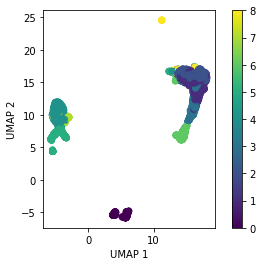

In [8]:
fig, ax = plt.subplots(1)
plot = ax.scatter(rna_umap[:,0], rna_umap[:,1], c=lowlevel)
ax.set_aspect('equal')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(plot)

In [9]:
# convert string labels to numeric
obs["highlevel"] = obs["highlevel"].fillna("nan")
highlevel_map = {lab:i for i,lab in enumerate(np.unique(obs["highlevel"]))}
highlevel = np.array([highlevel_map[i] for i in obs["highlevel"]])
highlevel_map 

{'B-Cells': 0, 'Monocytes': 1, 'NK Cells': 2, 'T-Cells': 3}

No handles with labels found to put in legend.


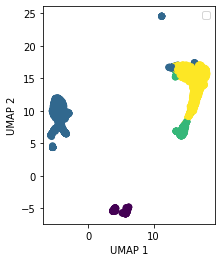

In [10]:
fig, ax = plt.subplots(1)
plot = ax.scatter(rna_umap[:,0], rna_umap[:,1], c=highlevel)
ax.set_aspect('equal')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend()

In [11]:
X = [torch.tensor(rna.values), torch.tensor(adt.values)]
llh=["gaussian", "gaussian"]
views = ["rna", "adt"]

In [12]:
model = spFA(X, 
            llh, 
            num_factors=5,
            views=views, 
            y = torch.tensor(highlevel), 
            target_llh = "multinomial",
            supervised_factors=1,
            device=torch.device('cuda'),
            ard = True,
            horseshoe = True,
            subsample=0)

model.fit_spFA(n_steps=3000, lr=0.01)

Current Elbo 1.72E+06 | Delta: 1822894: 100%|██████████| 3000/3000 [03:07<00:00, 15.99it/s]


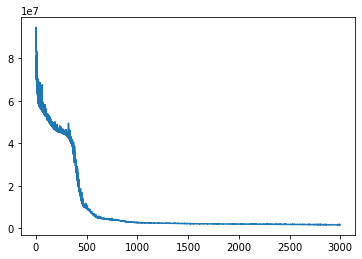

In [13]:
plt.plot(model.history)
#model.fit_spFA(n_steps=5000, lr=0.005)

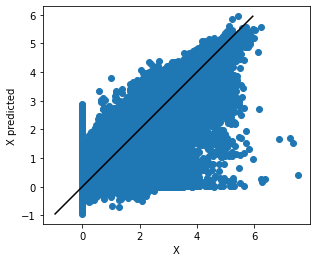

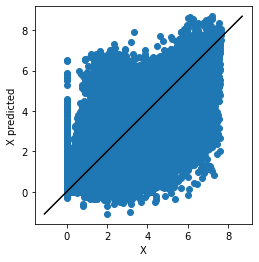

In [14]:
Z_pred = model.get_factors()
W_pred1 = model.get_loadings(view=0)
W_pred2 = model.get_loadings(view=1)
X_pred0 = model.get_Xpred(view=0)
X_pred1 = model.get_Xpred(view=1)


X0 = X[0].numpy()
X1 = X[1].numpy()


# check reconstructions of data
fig, ax = plt.subplots(1)
ax.scatter(X0, X_pred0)
ax.plot([np.min(X_pred0), np.max(X_pred0)], [np.min(X_pred0), np.max(X_pred0)], color = "black")
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("X predicted")
plt.show()
plt.close()


# check reconstructions of data
fig, ax = plt.subplots(1)
ax.scatter(X1, X_pred1)
ax.plot([np.min(X_pred1), np.max(X_pred1)], [np.min(X_pred1), np.max(X_pred1)], color = "black")
ax.set_aspect('equal')
plt.xlabel("X")
plt.ylabel("X predicted")
plt.show()
plt.close()

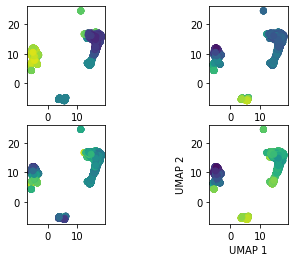

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i,ax in enumerate(fig.axes):
    plot = ax.scatter(rna_umap[:,0], rna_umap[:,1], c=Z_pred[:,i])
    ax.set_aspect('equal')
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    #ax.colorbar(plot)

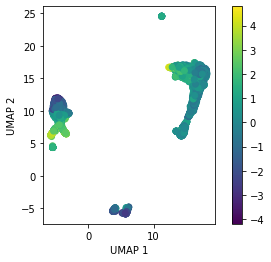

In [16]:
fig, ax = plt.subplots(1)

plot = ax.scatter(rna_umap[:,0], rna_umap[:,1], c=Z_pred[:,2])
ax.set_aspect('equal')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(plot)

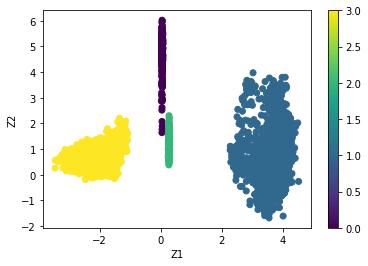

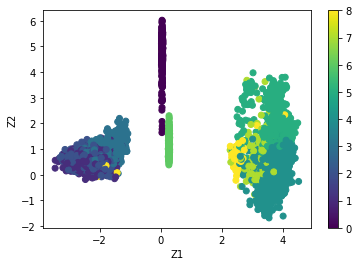

In [17]:
fig, ax = plt.subplots(1)
plot = ax.scatter(Z_pred[:,0],Z_pred[:,1], c = highlevel)
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.colorbar(plot)
plt.show()
plt.close()

fig, ax = plt.subplots(1)
plot = ax.scatter(Z_pred[:,0],Z_pred[:,1], c = lowlevel)
plt.xlabel("Z1")
plt.ylabel("Z2")
plt.colorbar(plot)
plt.show()
plt.close()

In [18]:
um = umap.UMAP()
Z_umap=um.fit_transform(Z_pred)

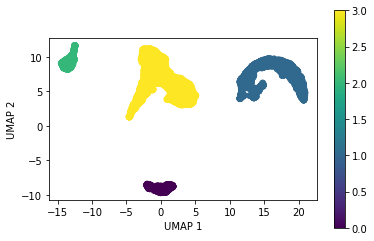

In [19]:
fig, ax = plt.subplots(1)
plot = ax.scatter(Z_umap[:,0], Z_umap[:,1], c=highlevel)
ax.set_aspect('equal')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(plot)

In [20]:
highlevel_map

{'B-Cells': 0, 'Monocytes': 1, 'NK Cells': 2, 'T-Cells': 3}

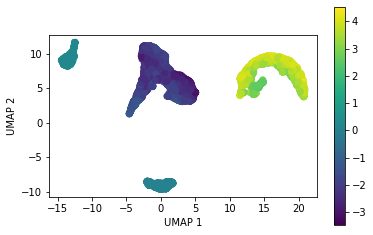

In [22]:
fig, ax = plt.subplots(1)
plot = ax.scatter(Z_umap[:,0], Z_umap[:,1], c=Z_pred[:,0])
ax.set_aspect('equal')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(plot)

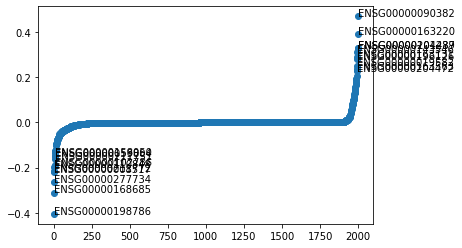

In [23]:
W0 = pd.DataFrame(W_pred1, columns = rna.columns)
W1 = pd.DataFrame(W_pred2, columns = adt.columns)

plot_weights(W0, factor=0)

(<BarContainer object of 2 artists>, [0.6559015914100899, 0.9045115731300836])

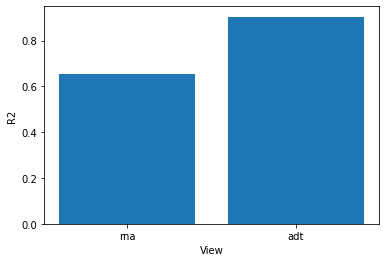

In [24]:
plot_variance_explained_view(model, X)

(<matplotlib.image.AxesImage at 0x7ffeb1ce5550>,
 array([[0.14039605, 0.04251582],
        [0.09478632, 0.17297591],
        [0.01404371, 0.01007979],
        [0.4099598 , 0.66637167],
        [0.06498339, 0.05571219]]))

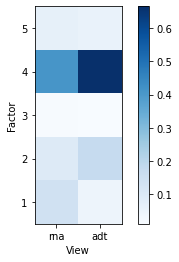

In [25]:
plot_variance_explained(model, X)